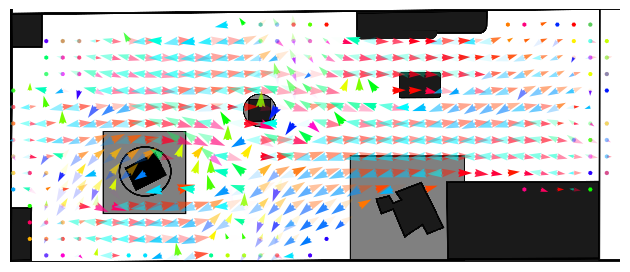

In [26]:
import os

import pandas as pd
import numpy as np

import matplotlib.cm as cm
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
from PIL import Image
from explore_utils import PixWorldConverter
from matplotlib.ticker import FixedLocator, FixedFormatter
import plot_cliff


def cart2pol(x, y):
    rho = np.sqrt(x ** 2 + y ** 2)
    phi = np.arctan2(y, x)
    return (rho, phi)


def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return (x, y)

def plot_cliff_map_with_weight(cliff_map_data, model_type="all"):

    ## Only leave the SWND with largest weight
    max_index_list = []
    
    location = cliff_map_data[0, :2]
    orientation = cliff_map_data[:, 2]
    weight = cliff_map_data[0, 8]
    max_weight_index = 0

    for i in range(1, len(cliff_map_data)):
        tmp_location = cliff_map_data[i, :2]
        if (tmp_location == location).all():
            tmp_weight = cliff_map_data[i, 8]
            if tmp_weight > weight:
                max_weight_index = i
                weight = tmp_weight
        else:
            max_index_list.append(max_weight_index)
            location = cliff_map_data[i, :2]
            weight = cliff_map_data[i, 8]
            max_weight_index = i

    max_index_list.append(max_weight_index)

    (u, v) = pol2cart(cliff_map_data[:, 3] * 100, orientation)
    weight = cliff_map_data[:, 8]
    
    if model_type == "online":
        motion_r = cliff_map_data[:, 10]
        motion_r = motion_r / motion_r.max()
    else:
        motion_r = cliff_map_data[:, 9]
        motion_r = motion_r / motion_r.max()

#### If use color to show direction ####
    colors = cliff_map_data[:, 2]  * 180 / np.pi
    colors = np.append(colors, [0, 360])
    norm = Normalize()
    norm.autoscale(colors)
    colormap = cm.hsv
    
    
    
#### If use color to show motion-ratio ####
    # colors = motion_r
    # # colors = np.append(colors, [0, 1])
    # norm = Normalize()
    # norm.autoscale(colors)
    # colormap = cm.viridis

    # cbar = plt.colorbar()
    # cbar.ax.tick_params(labelsize=25)
            
    # plt.quiver(cliff_map_data[:, 0], cliff_map_data[:, 1], u, v, color=colormap(norm(colors)), alpha=weight, cmap="hsv",angles='xy', scale_units='xy', scale=1.5)
    

    ##### If plot only max weight component or use transparency to show the weight of each component #####    
    for i in range(len(cliff_map_data)):
    # for i in range(200):
        ## For only plot max weight:
        # if i in max_index_list:
            # plt.quiver(cliff_map_data[i, 0], cliff_map_data[i, 1], u[i], v[i], color=colormap(norm(colors))[i], alpha=1, cmap="hsv",angles='xy', scale_units='xy', scale=0.7)
        ## For only plot one point:
        # if cliff_map_data[i, 0] == 20 and cliff_map_data[i, 1] == -13:

        plt.quiver(cliff_map_data[i, 0], cliff_map_data[i, 1], u[i], v[i], color=colormap(norm(colors))[i], alpha=weight[i], cmap="hsv",angles='xy', scale_units='xy', scale=3)




def plot_full_cliff(cliffmap, fig_dir, map_dir, model_type="all"):
    plt.clf()
    plt.close('all')
    
    img = np.array(Image.open(map_dir))
    spatial_layout = np.flipud(img[:, :, :3])
    plt.imshow(spatial_layout)
    
    visuals_info = {"resolution_pm" : 0.01, "offset": [-860, -1050]}
    converter = PixWorldConverter(visuals_info)

    
    cliff_map_data = pd.read_csv(cliffmap, header=None)
    
    if model_type == "online":
        cliff_map_data.columns = ["x", "y", "velocity", "motion_angle", "cov4", "cov2", "cov3", "cov1", "weight", "motion_ratio", "decay_rate"]
        cliff_map_data = cliff_map_data[['x', 'y', 'motion_angle', 'velocity', 'cov1', 'cov2', 'cov3', 'cov4', 'weight', 'motion_ratio', 'decay_rate']]
        cliff_map_data['weight'] = cliff_map_data.groupby(['x', 'y'])['weight'].transform(lambda x: x / x.sum())
        cliff_map_data['motion_angle'] = np.mod(cliff_map_data['motion_angle'], 2 * np.pi)
        
        filter_condition = (cliff_map_data['cov1'] != 0) | (cliff_map_data['cov2'] != 0) | (cliff_map_data['cov3'] != 0) | (cliff_map_data['cov4'] != 0)
        cliff_map_data = cliff_map_data[filter_condition]
    else:
        cliff_map_data.columns = ["x", "y", "motion_angle", "velocity",
                        "cov1", "cov2", "cov3", "cov4", "weight", "motion_ratio"]
        
        # MoD['weight'] = MoD.groupby(['x', 'y'])['weight'].transform(lambda x: x / x.sum())
        cliff_map_data['motion_angle'] = np.mod(cliff_map_data['motion_angle'], 2 * np.pi)
    
    cliff_map_data = cliff_map_data.to_numpy()
    cliff_xy_pixels = converter.convert2pixels(cliff_map_data[:, 0:2])
    
    cliff_map_data[:, 0:2] = cliff_xy_pixels
    
    
    
    if model_type == "online":
        cliff_map_data[:, 1] = cliff_map_data[:, 1] - 30
    
    ## remove rows where y smaller than 1200
    # cliff_map_data = cliff_map_data[cliff_map_data[:, 1] > 1200]
    # cliff_map_data = cliff_map_data[cliff_map_data[:, 1] < 1350]
    
    
    plot_cliff_map_with_weight(cliff_map_data, model_type)

    # # print(converter.convert2world(np.array([robot_pos_pix[0]])))
    # # Convert the pixel tick labels to world coordinates (meters)
    # ax = plt.gca()
    # x_ticks_pix = ax.get_xticks()
    # y_ticks_pix = ax.get_yticks()
    
    # # Convert x ticks
    # x_ticks_pix_pairs = np.column_stack((x_ticks_pix, np.zeros_like(x_ticks_pix)))
    # x_ticks_world = converter.convert2world(x_ticks_pix_pairs)[:, 0]

    # # Convert y ticks
    # y_ticks_pix_pairs = np.column_stack((np.zeros_like(y_ticks_pix), y_ticks_pix))
    # y_ticks_world = converter.convert2world(y_ticks_pix_pairs)[:, 1]
    
    # ax.xaxis.set_major_locator(FixedLocator(x_ticks_pix))
    # ax.xaxis.set_major_formatter(FixedFormatter([f'{x:.1f}' for x in x_ticks_world]))
    # ax.yaxis.set_major_locator(FixedLocator(y_ticks_pix))
    # ax.yaxis.set_major_formatter(FixedFormatter([f'{y:.1f}' for y in y_ticks_world]))
    
    # plt.axis('equal')
    plt.axis("off")

    plt.tight_layout()
    # plt.gca().invert_yaxis()
    
    ## For check the corridor
    # plt.xlim([1000, 1500])
    # plt.ylim([1200, 1400])
    
    ## For check the floor marking 1
    # plt.xlim([100, 700])
    # plt.ylim([700, 1300])

    
    ### For view all
    plt.xlim([0, 1850])
    plt.ylim([650, 1417])
    
    # plt.show()
    # print(fig_dir)
    plt.savefig(fig_dir, bbox_inches='tight')
    

def plot_main_process_figure_magni(magni_folder, model_type):
    ##### Plot full cliff map #####
    # model_type = "interval"
    # magni_folder = "online_mod_res_magni_A_first_split_random_online"
    # save_folder = f"{magni_folder}/figures/{model_type}_blue"
    # save_folder = f"{magni_folder}/figures/quality_res_all"
    save_folder = f"magni-res-v2/figures_v3"
    os.makedirs(save_folder, exist_ok=True)
    

    # for exp_type in ["A", "B"]:
    for exp_type in ["B"]:
        map_dir = f'thor_magni_maps/1205_SC1{exp_type}_map.png'
        # map_dir = f'thor_magni_maps/1205_SC1A_map.png'
        # for batch in range(5, 6):
        for batch in range(4, 5):
            if model_type == "online":
                cliff_file = f'{magni_folder}/{exp_type}_b{batch}_online.csv'
            else:
                cliff_file = f'{magni_folder}/{exp_type}_b{batch}_cliff.csv'
                
            if model_type == "history":
                fig_file = f"{save_folder}/history_{exp_type}_b{batch}.png",
            elif model_type == "online":
                fig_file = f"{save_folder}/{model_type}_decay_0.1_{exp_type}_b{batch}.png"
            else:
                fig_file = f"{save_folder}/{model_type}_{exp_type}_b{batch}.png"
            plot_full_cliff(
                cliff_file, 
                # f"{save_folder}/robotzone_{model_type}_{exp_type}_b{batch}.pdf", 
                # f"{save_folder}/corridor_{model_type}_{exp_type}_b{batch}.png", 
                fig_file, 
                map_dir,
                model_type)


# plot_main_process_figure_magni(f"magni-res-v2/cliff/interval_train", "interval")
# plot_main_process_figure_magni(f"magni-res-v2/cliff/window_train", "window")
# plot_main_process_figure_magni(f"magni-res-v2/cliff/all_train", "all")

# plot_main_process_figure_magni(f"magni-res-v2/cliff/online_res/try5/decay_0.1", "online")
# plot_main_process_figure_magni(f"magni-res-v2/cliff/online_train/decay_0.1", "online")
